### Context
In this project, we will build an image classifier to classify dogs vs cats. We have downloaded the dataset from [here](https://www.kaggle.com/c/dogs-vs-cats/overview). Although this data has a total of 25k images. But for this project, we will only 600 images (400 train and 200 validation images). The reason for selecting less number of images is to show you - how to augment images when we don't have much data to train the network.

### Objectives
The objectives of this project is to - 
1. Load and understand the data
2. Automatic labelling of the images
3. Performing data augmentation
4. Building classification models using CNN
5. Improving the model using transfer learning



### Importing libraries

In [1]:
# library for creating data paths
import os

# library for randonly selecting data points
import random

# library for performing numerical computations
import numpy as np

# library for creating and showing plots
import matplotlib.pyplot as plt

# library for reading and showing images
import matplotlib.image as mpimg

# importing all the required sub-modules from keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

Mounting the drive to load the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We have stored the images in a structured folder and below we are creating the data paths to load images from those folders. This is required so that we can extract images in an auto labelled fashion using keras **flow_from_directory**. Below is a schematic of the folder structure - 

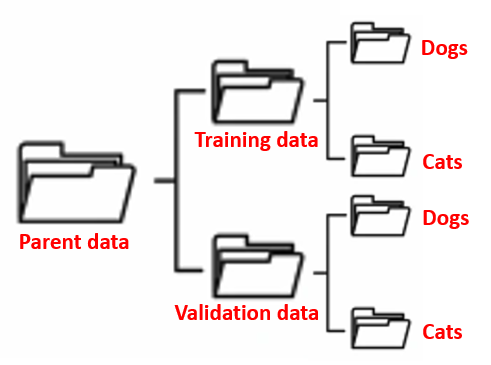![folder structure](images/folder_structure.PNG)

In [3]:
# parent directory where images are stored in drive
parent_dir = '/content/drive/My Drive/Analytics Vidhya Computer Vision Workshop/dogs-vs-cats'

# path to the training and validation datasets within the parent directory
train_dir = os.path.join(parent_dir, 'train')
validation_dir = os.path.join(parent_dir, 'validation')

# directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Observing some of the images

Before we move ahead and perform data augmentation, let's check some of the images randomly and see how it looks like

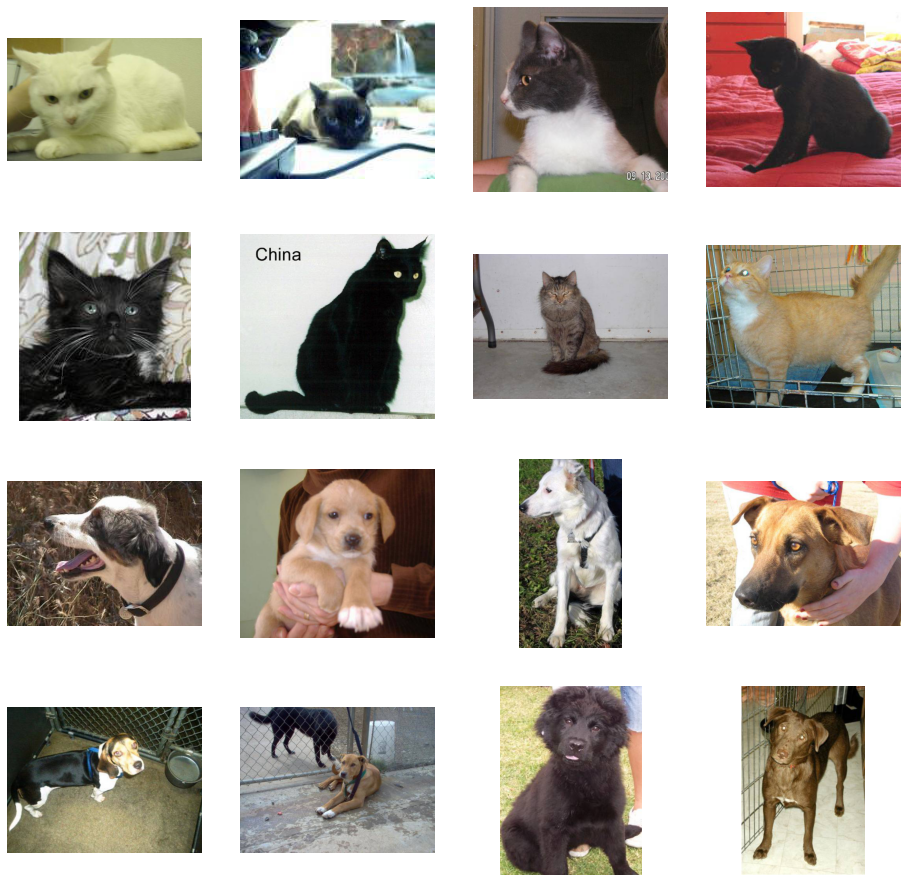

In [4]:
train_cat_file_names = os.listdir(train_cats_dir)
train_dog_file_names = os.listdir(train_dogs_dir)

fig = plt.figure(figsize=(16, 8))
fig.set_size_inches(16, 16)

cat_img_paths = [os.path.join(train_cats_dir, file_name) for file_name in train_cat_file_names[:8]]
dog_img_paths = [os.path.join(train_dogs_dir, file_name) for file_name in train_dog_file_names[:8]]

for i, img_path in enumerate(cat_img_paths + dog_img_paths):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

As we can see, the images are all not same. Some images are small, some are big. But most of the CNN architectures including pre-built model architectures which we will use for transfer learning, they expect the images to have same size. So we need to crop these images from center. We can do this automatically while doing data augmentation, as shown below.

### Data Augmentation

In most of the real life case studies, it is generally difficult to collect lots and lots of images and then train the CNNs. In that case we can take help of the data augmentation techniques. CNNs have the property of **translational invariance** i.e it can recognize an object as an object, even when its appearance varies in some way. Taking this property into consideration, we can augment the images using following techniques - 

1. Horizontal flip (should be set to True/False)
2. Vertical flip (should be set to True/False)
3. Height Shift (should be between 0 and 1)
4. Width Shift (should be between 0 and 1)
5. Rotation (should be between 0 and 180)
6. Shear (should be between 0 and 1)
7. Zoom (should be between 0 and 1) etc.

We will try out different values for the parameters, and then make some conclusions after visualizing the images. What values of the above the parameters might or might not be appropriate for these imaging based on what we might see in the real world. Remember ***not to use data augmentation in validation data set***.

Also, as mentioned above, we need to have images of same size, below we are cropping the images from middle automatically by using the parameter **target_size**. Here we are cropping it to the size **224 x 224**, as we will be using **VGG16** model which takes the image input as **224 x 224**. If you want to use any other pre-built architectures, then you might need to change this size.

In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))     

# Flowing validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 402 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


Look at some examples of our augmented training data. This is helpful for understanding the extent to which data is being manipulated prior to training, and can be compared with how the raw data look prior to augmentation

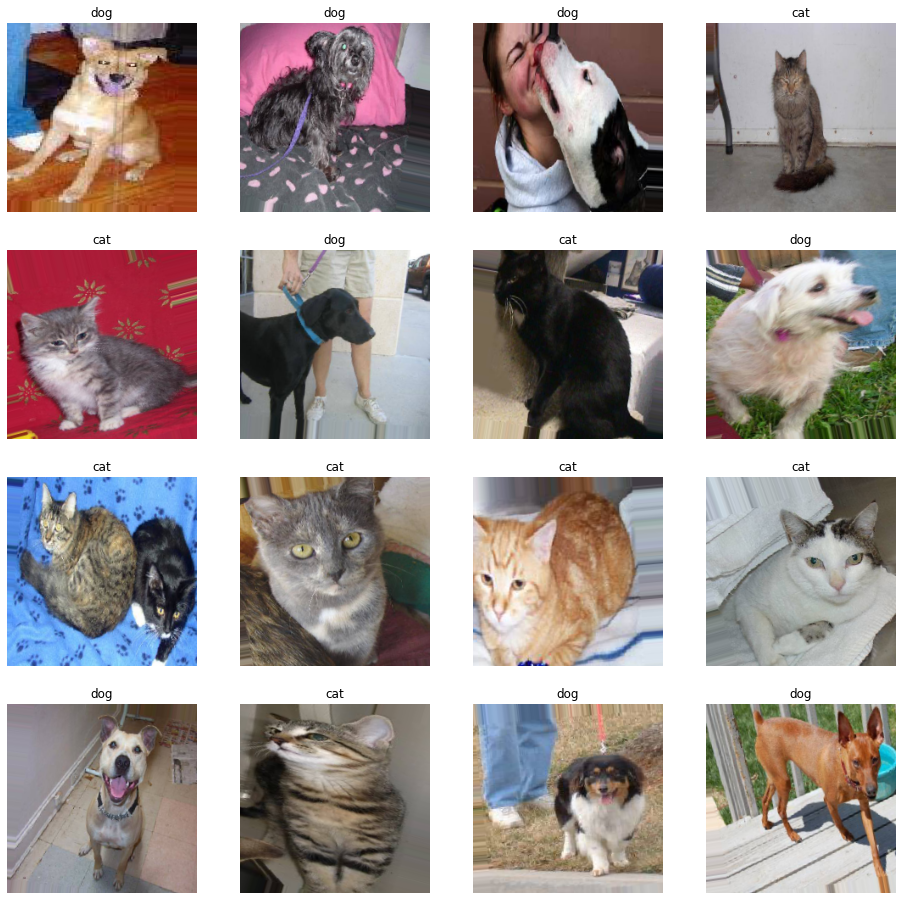

In [ ]:
images, labels = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label == 1: 
        ax.set_title('dog')
    else:
        ax.set_title('cat')
    ax.axis('off')

You can now compare the above augmented images with the original images, and see the difference for yourself.

### Model building using CNN

Once the data is augmented and cropped to have same size, we are now ready to build a first baseline CNN model to classify dogs vs cats

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(32, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation='relu'))

cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics = ['accuracy'])

In [ ]:
cnn_model.summary()

In [ ]:
## pulling a single large batch of random validation data for testing after each epoch
testX, testY = validation_generator.next()

In [ ]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

Below I am using the parameter **steps_per_epoch=100**, as it was taking longer to train. If you are interested to run this notebook, please remove this parameter and train the model again. This will improve the performance.

In [ ]:
model_history = cnn_model.fit(train_generator, 
                                  validation_data=(testX, testY),
                                  callbacks=[stop_early],
                                  epochs=10)

### Model building using transfer learning

Now we are building a model using the concepts of **transfer learning**. We will be loading pre-built architecture **VGG16** which is trained on imagenet dataset. And then we will freeze the weights of first few initial layers and train only the last layers using our own data. Below is a schematic of the VGG16 model - 

![transfer learning](images/transfer_learning.PNG)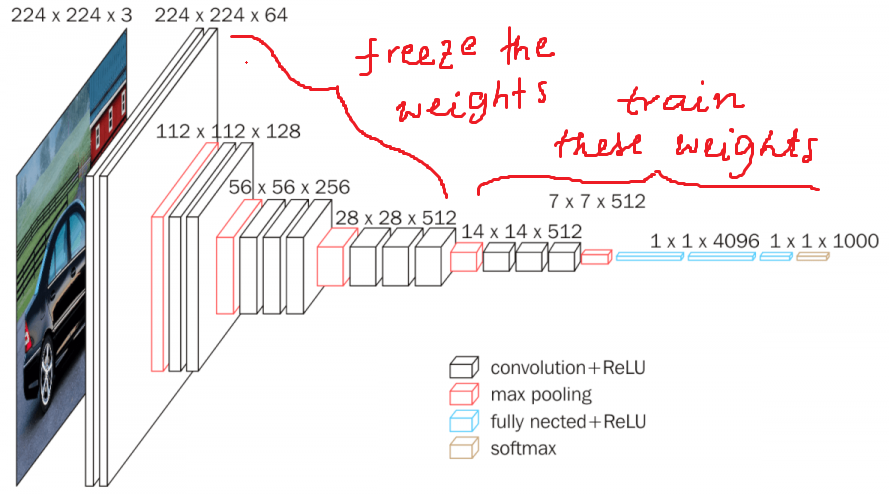

In [ ]:
model = VGG16(include_top=True, weights='imagenet')
model.summary()

In [ ]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [ ]:
vgg_model.summary()

In [ ]:
# we will choose which layers of VGG16 we actually want to fine-tune. Here we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [ ]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

In [ ]:
new_model = Sequential()

# adding the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# flattening the output of the VGG16 model because it is from a convolutional layer.
new_model.add(Flatten())

# adding a dense output layer.
new_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# setting optimizer, loss function, and learning rate
# optimizer = Adam(learning_rate=1e-4)
optimizer = "Adam"
loss = 'binary_crossentropy'
metrics = ['accuracy']

In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
new_model.summary()

In [ ]:
## fitting the model
new_model_history = new_model.fit(train_generator, 
                                  validation_data=(testX, testY),
                                  callbacks=[stop_early],
                                  epochs=10)

In [ ]:
# function to plot loss, val_loss, 
def plot_history(history):
    N = len(history.history["loss"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

In [ ]:
# plotting the loss vs epoch curve for basic CNN model without transfer learning
plot_history(model_history)

In [ ]:
# plotting the loss vs epoch curve for basic CNN model without transfer learning
plot_history(new_model_history)

You can see the difference in both models. The transfer learning model has converged faster than the basic CNN model. Just check the loss values in both the models. For the basic CNN models, the loss started with ~0.8, but for the transfer learning model the loss started with 0.35. That's good improvement just by using pre-trained architectures. This model further needs to be tuned. You can try this out by using all the hyper-parameter tuning techniques you have learnt so far.